## Boston Housing Data

This is a notebook to explore the elements that **impact the housing prices in Boston, MA**. This data set is taken from [Kaggle](https://www.kaggle.com/datasets/altavish/boston-housing-dataset).

The goal of the notebook is to practice linear regression and understand all of the elements necessary to go through when creating a model.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import pearsonr

#### **Get an idea of what the data looks like**

Here's a list of the column names and their meanings:
- CRIM - per capita crime rate by town

- ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

- INDUS - proportion of non-retail business acres per town.

- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

- NOX - nitric oxides concentration (parts per 10 million)

- RM - average number of rooms per dwelling

- AGE - proportion of owner-occupied units built prior to 1940

- DIS - weighted distances to five Boston employment centres

- RAD - index of accessibility to radial highways

- TAX - full-value property-tax rate per $10,000

- PTRATIO - pupil-teacher ratio by town

- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

- LSTAT - % lower status of the population

- MEDV - Median value of owner-occupied homes in $1000's

In [2]:
housing = pd.read_csv('HousingData.csv')
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [3]:
housing['CRIM_Inv'] = housing['CRIM'] ** -1
housing['Ln_MEDV'] = np.log(housing['MEDV'])
housing

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CRIM_Inv,Ln_MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,158.227848,3.178054
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,36.616624,3.072693
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,36.643459,3.546740
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,30.892802,3.508556
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2,14.482259,3.589059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4,15.966789,3.109061
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6,22.089684,3.025291
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9,16.458196,3.173878
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0,9.124920,3.091042


#### **Let's look at the percentage missing**

What this will do is help us determine if we should drop any null values if there is a high # of missing.

In [4]:
pct_missing = housing.isna().sum()/len(housing)
pct_missing

# small percentages of missing data

CRIM        0.039526
ZN          0.039526
INDUS       0.039526
CHAS        0.039526
NOX         0.000000
RM          0.000000
AGE         0.039526
DIS         0.000000
RAD         0.000000
TAX         0.000000
PTRATIO     0.000000
B           0.000000
LSTAT       0.039526
MEDV        0.000000
CRIM_Inv    0.039526
Ln_MEDV     0.000000
dtype: float64

### **Creating training, validation and testing data**

In order to create a predictive model, we need to break the data into three subsets; training, validation and testing subsets.

We use the training dataset to understand the patterns and relationships the data has.

The validation data set is for evaluating the trained model. We can assess model performance and fine tune the parameters. At this stage we can see how well the model is learning and adapting, allowing for adjustments and optimizations to be made to the model's parameters or hyperparameters.

Testing is the unseen dataset. This is at the very end, when we are ready to have an unbiased model evaluation.

#### **Function for creating training, validation and testing dataset**

In [5]:
def train_validate_test_split(df, train_percent=.7, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [6]:
train, validate, test = train_validate_test_split(housing)

In [7]:
# model will not train on null values
train = train.dropna()

In [8]:
# model will not train on null values
validate = validate.dropna()

### **Getting a high level look at what variables may have a relationship, using the training dataset**

We'll use this to get started on investigating.

In [9]:
def correlation_matrix(df: pd.DataFrame):
    """
    A function to calculate and plot
    correlation matrix of a DataFrame.
    """
    # Create the matrix
    matrix = df.corr()
    
    # Create a mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    reduced_matrix = matrix.mask(mask)
    # Make figsize bigger
    fig, ax = plt.subplots(figsize=(16,12))
    
    # Plot the matrix
    _ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap='bwr', ax=ax)
    
    return matrix

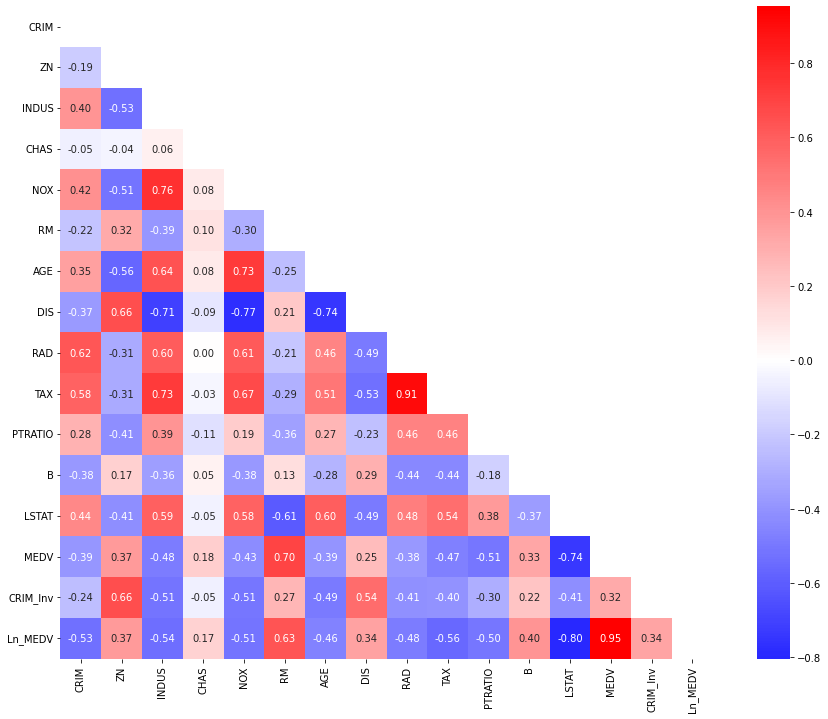

In [10]:
corr_matrix = correlation_matrix(housing)

In [11]:
correlation_with_medv = corr_matrix['MEDV']

# Display correlation coefficients
print(correlation_with_medv)

CRIM       -0.391363
ZN          0.373136
INDUS      -0.481772
CHAS        0.181391
NOX        -0.427321
RM          0.695360
AGE        -0.394656
DIS         0.249929
RAD        -0.381626
TAX        -0.468536
PTRATIO    -0.507787
B           0.333461
LSTAT      -0.735822
MEDV        1.000000
CRIM_Inv    0.316063
Ln_MEDV     0.953155
Name: MEDV, dtype: float64


In [12]:
response_variable = 'MEDV'

# Loop through each independent variable and calculate correlation and p-value
for column in corr_matrix.columns:
    if column != response_variable:  # Skip the response variable itself
        correlation_coefficient, p_value = pearsonr(corr_matrix[column], corr_matrix[response_variable])
        
        # Output results
        print(f'Correlation coefficient for {column}: {correlation_coefficient:.4f}, p-value: {p_value:.4f}')
        
        # Check significance at 0.05 level
        if p_value < 0.05:
            print(f'{column} has a significant correlation with {response_variable}')
        else:
            print(f'{column} does not have a significant correlation with {response_variable}')
            
        print('\n')

Correlation coefficient for CRIM: -0.8680, p-value: 0.0000
CRIM has a significant correlation with MEDV


Correlation coefficient for ZN: 0.7873, p-value: 0.0003
ZN has a significant correlation with MEDV


Correlation coefficient for INDUS: -0.8787, p-value: 0.0000
INDUS has a significant correlation with MEDV


Correlation coefficient for CHAS: 0.2583, p-value: 0.3340
CHAS does not have a significant correlation with MEDV


Correlation coefficient for NOX: -0.8406, p-value: 0.0000
NOX has a significant correlation with MEDV


Correlation coefficient for RM: 0.9563, p-value: 0.0000
RM has a significant correlation with MEDV


Correlation coefficient for AGE: -0.8308, p-value: 0.0001
AGE has a significant correlation with MEDV


Correlation coefficient for DIS: 0.7574, p-value: 0.0007
DIS has a significant correlation with MEDV


Correlation coefficient for RAD: -0.8641, p-value: 0.0000
RAD has a significant correlation with MEDV


Correlation coefficient for TAX: -0.8908, p-value: 0.0

### **Results of the correlation coefficient testing**

#### Most of the variables have significance to the response variable. Now it is up to us to determine what impacts the MEDV the most.

### **Visual representation of what variables may have a relationship in the training dataset**

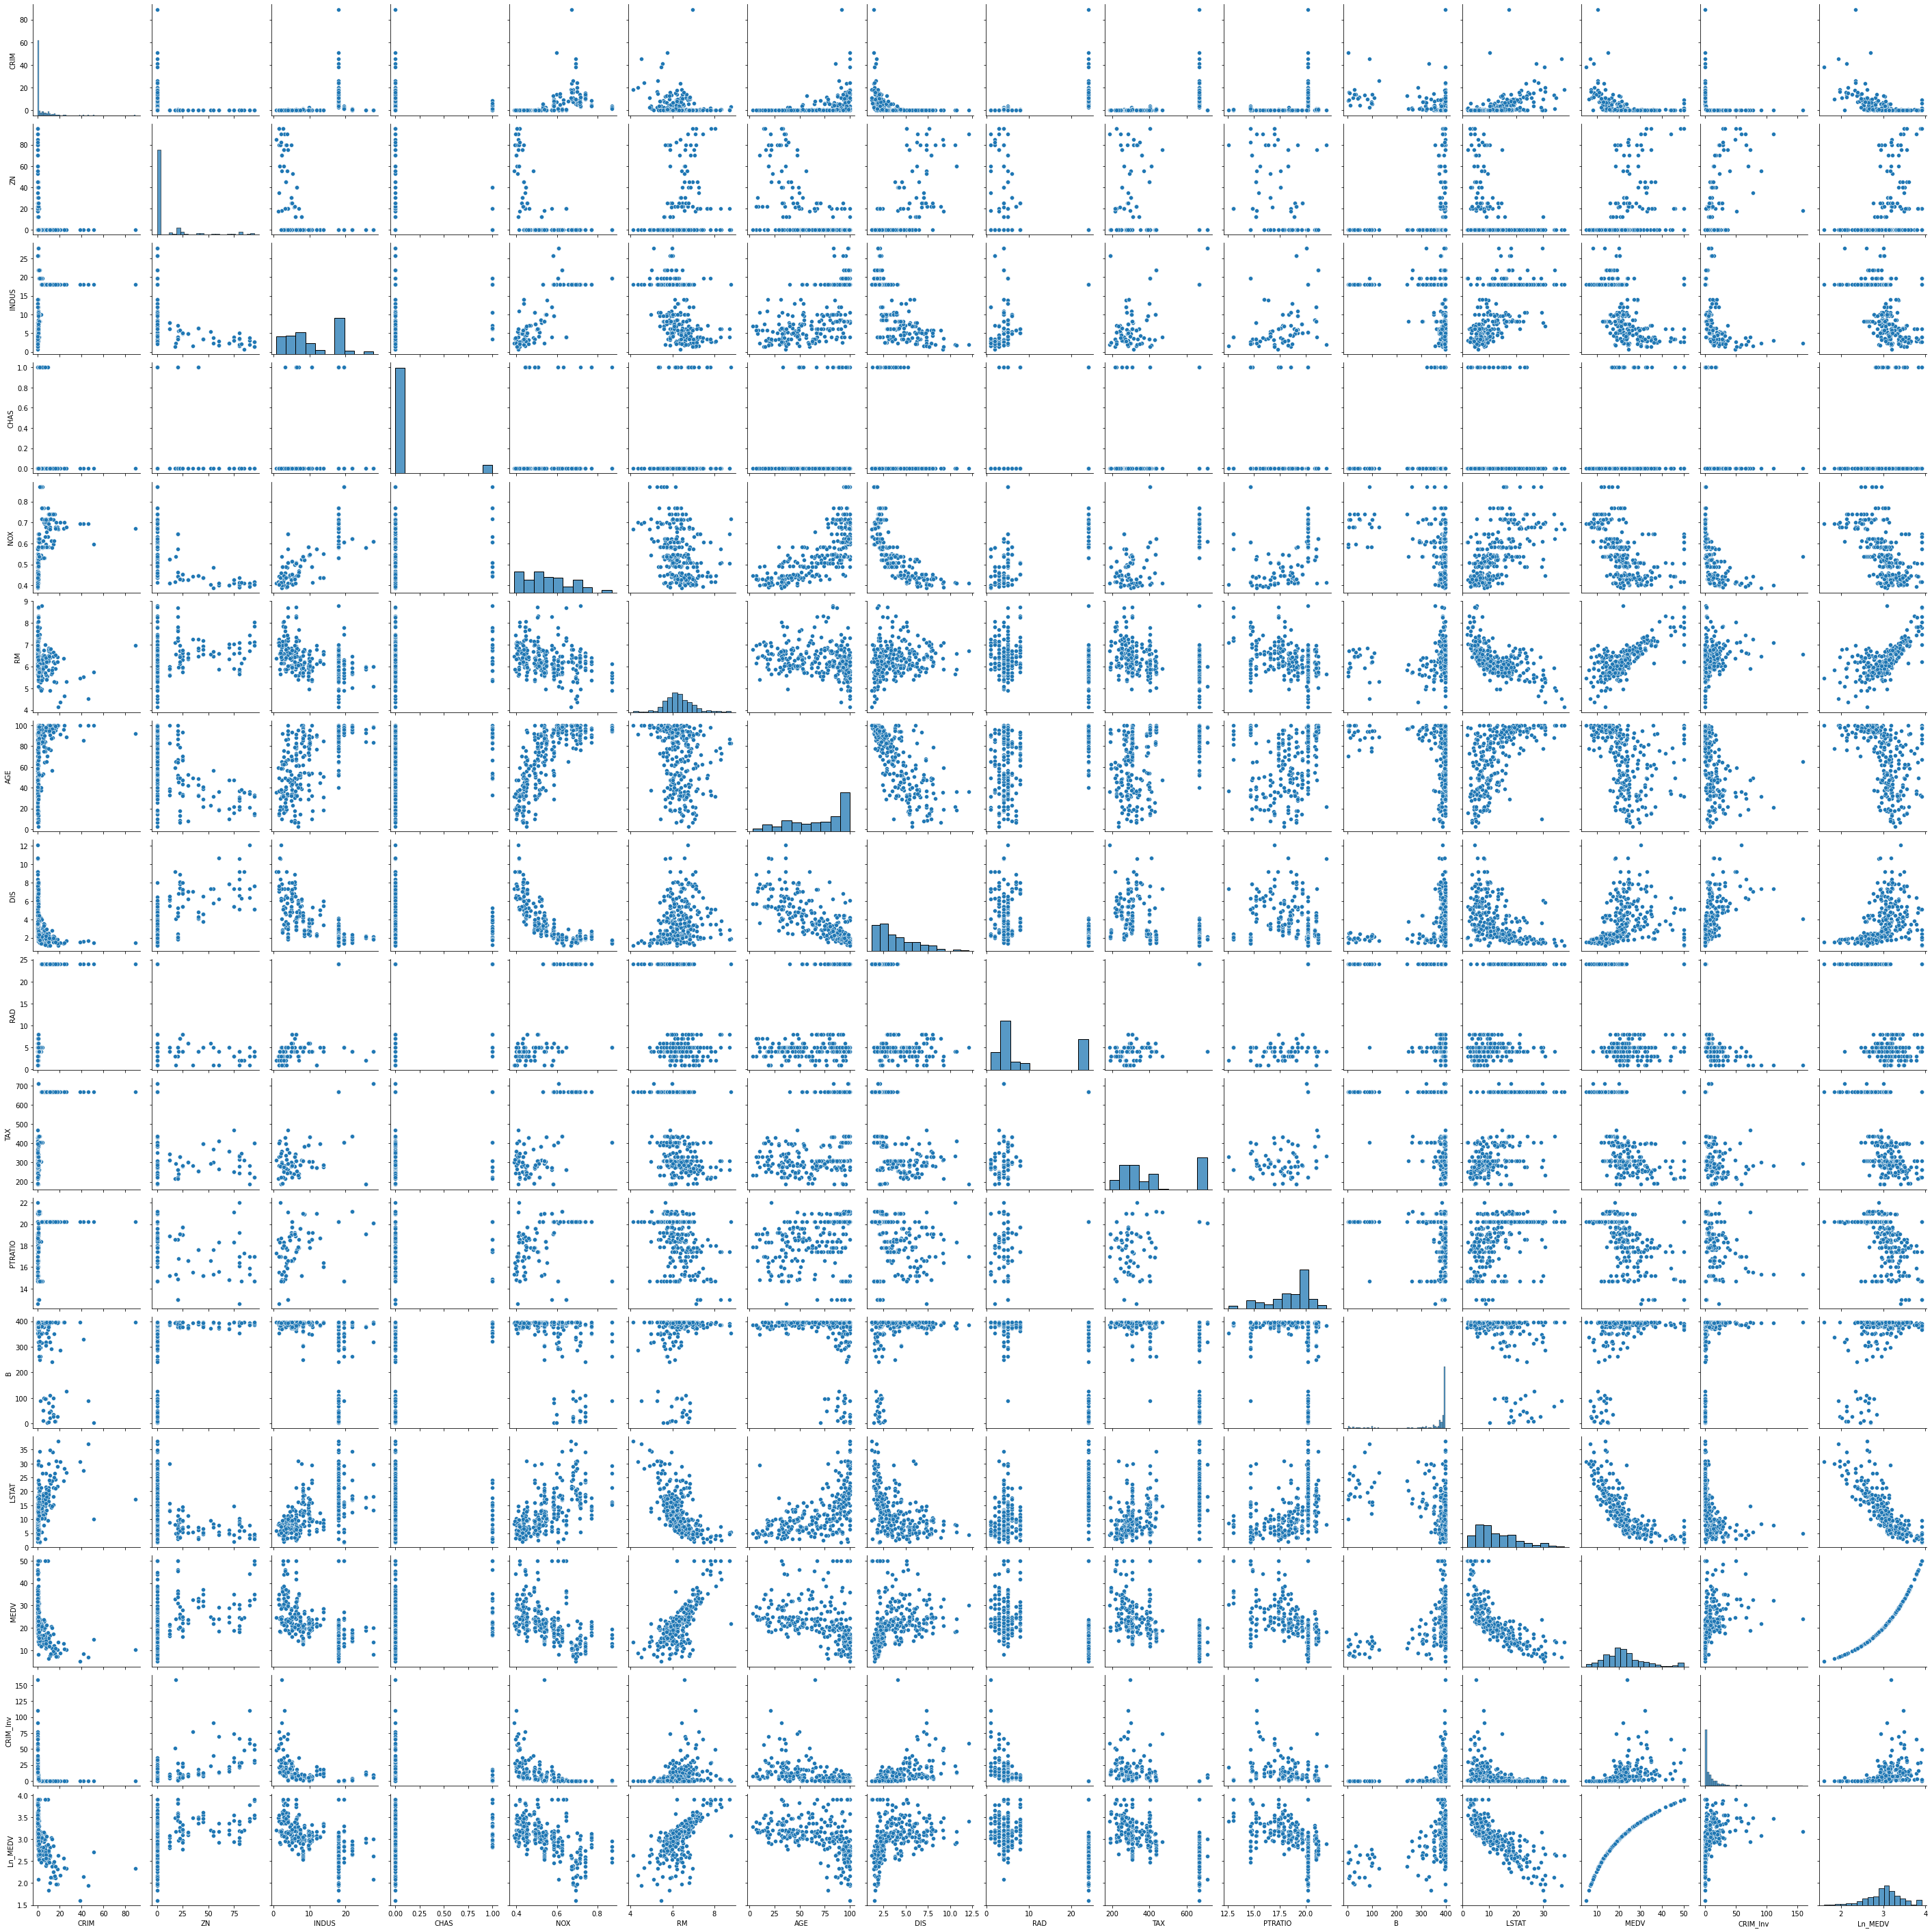

In [13]:
sns.pairplot(train)

/home/ishya/miniconda3/envs/prac/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


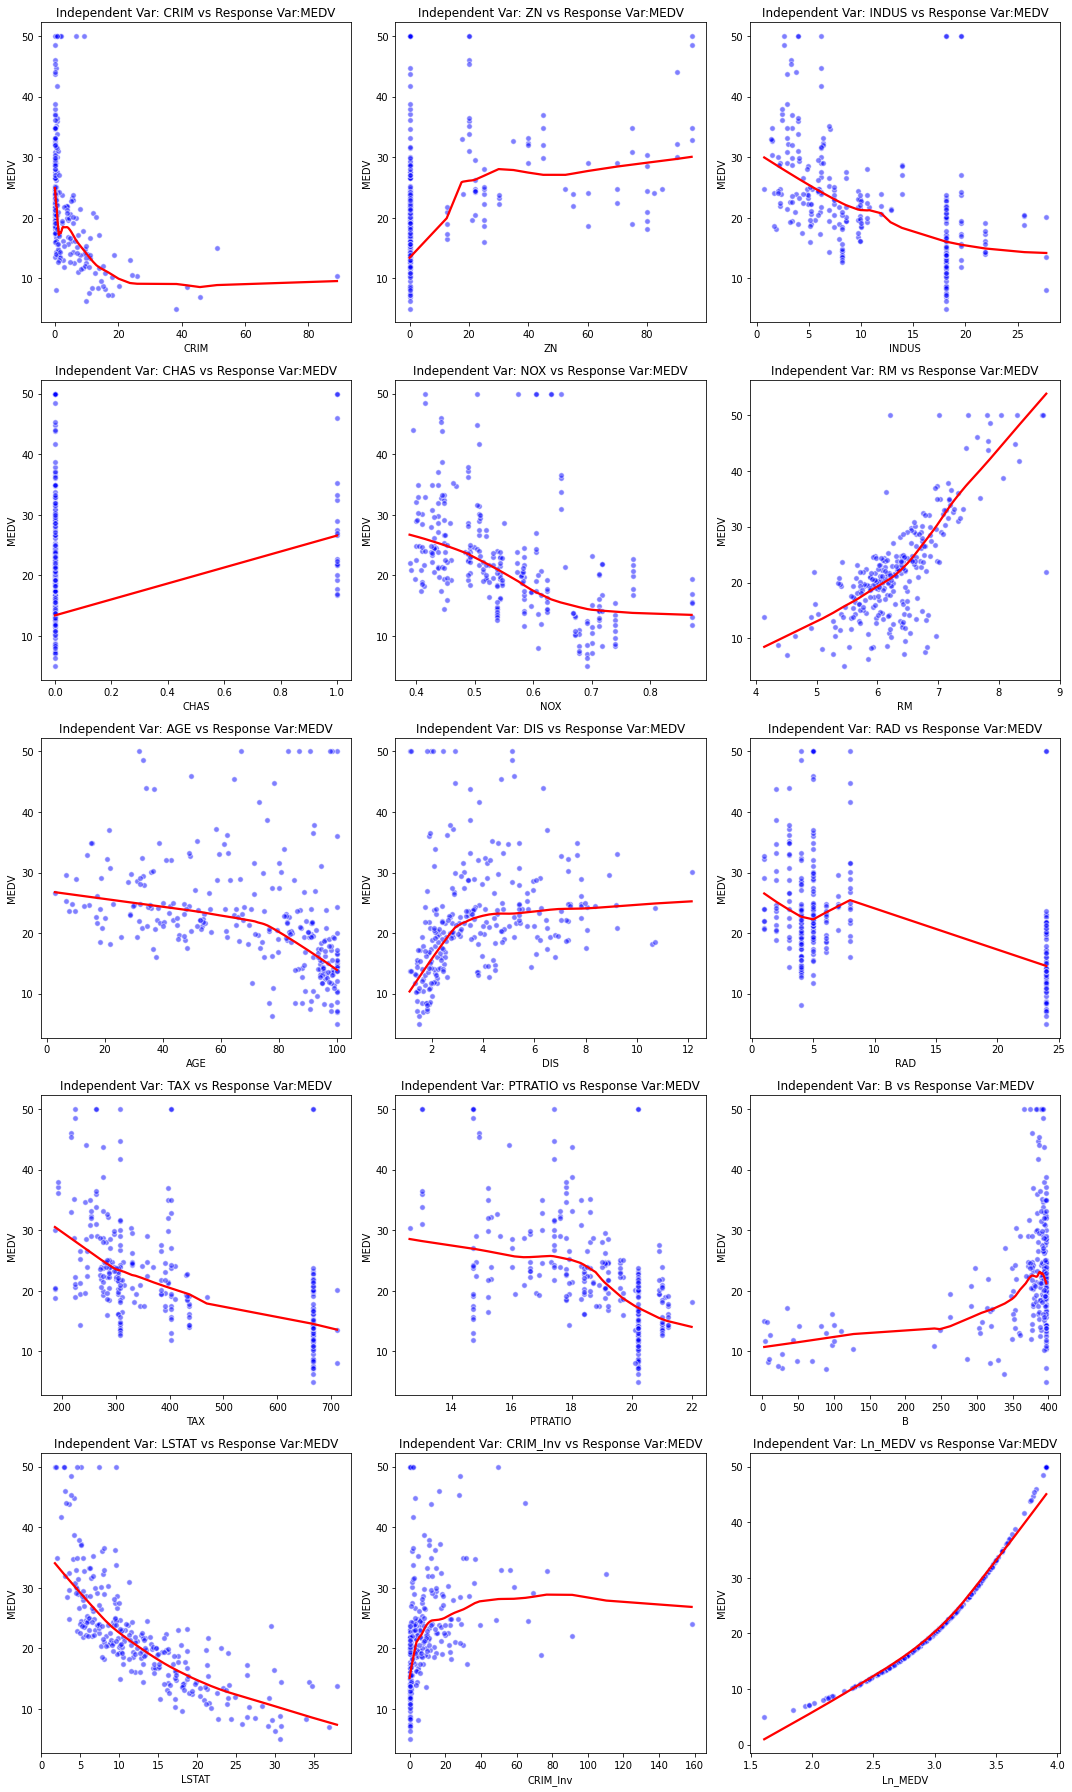

In [14]:
response_variable = 'MEDV'

# Get a list of independent variables
independent_variables = [col for col in train.columns if col != response_variable]

# Calculate the number of rows and columns for subplots
num_plots = len(independent_variables)
num_cols = 3  # Set the desired number of columns
num_rows = (num_plots - 1) // num_cols + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes if it's a multi-dimensional array
axes = axes.flatten()

# Create individual regression plots for each independent variable
for i, x_variable in enumerate(independent_variables):
    ax = axes[i]
    sns.regplot(data=train, x=x_variable, y=response_variable, lowess=True, scatter_kws=dict(alpha=0.5, s=30, color='blue', edgecolors='white'), ax=ax, line_kws={'color': 'red'})
    ax.set_title(f'Independent Var: {x_variable} vs Response Var:{response_variable}')

# Remove empty subplots if there are fewer plots than expected
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

#### **Choosing what variables may impact the housing price in Boston and creating the models**

From the Correlation tests, we see correlation between many of the independent variables and MEDV. We continue to search for what variables impact the MEDV.

From the correlation matrix and the pair plot these are the following variables that may seem to have the most impact on housing prices (MEDV);
- RM - average number of rooms per dwelling

- LSTAT- % lower status of the population

- TAX - full-value property-tax rate per $10,000

We take a snapshot of the MEDV Row and add an LOWESS (Locally Weighted Scatterplot Smoothing) line to get another view on what the data is like on MEDV.
- AGE seems to have some negative correlation

- DIS seems to have a positive correlation and then tapers to one value around 22 or 23.

- LSTAT has an exponential decrease it seems

- RM has exponential increase

- TAX has some weird association happening

From these new sets of reg plots, TAX and CRIM are behaving strangely. But with knowledge of the housing market, we know that property tax and crime rates can drastically affect the price of a house, so we will add those in the regression to take a look.

It should also be mentioned that we take CRIM inverse and natural log of MEDV for further exploration of the linear models.

From here, we make a few models - one with no interaction terms and a couple other models with different interaction terms.

In [15]:
X = train[['RM','LSTAT', 'CRIM','TAX']]

y = train['MEDV'] 
## fit a OLS model with intercept on TV and Radio 
X = sm.add_constant(X) 
model_1 = ols('MEDV ~ RM + LSTAT + CRIM + TAX', data=train).fit() 
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     154.2
Date:                Sat, 06 Jan 2024   Prob (F-statistic):           8.50e-69
Time:                        14:14:07   Log-Likelihood:                -843.56
No. Observations:                 278   AIC:                             1697.
Df Residuals:                     273   BIC:                             1715.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.5171      4.212     -1.547      0.123     -14.810       1.776
RM             5.9937      0.584     10.268      0.000       4.844       7.143
LSTAT         -0.3883      0.064     -6.075      0.000      -0.514      -0.262
CRIM          -0.0598      0.045     -1.342      0.181      -0.148       0.028
TAX           -0.0093      0.002     -3.813      0.000      -0.014      -0.004
==============================================================================
Omnibus:                      110.507   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.174
Skew:                           1.598   Prob(JB):                    5.46e-110
Kurtosis:                       8.765   Cond. No.                     6.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
model_2 = ols('MEDV ~ RM + LSTAT + CRIM + TAX + TAX:RM', data = train).fit() 
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     178.6
Date:                Sat, 06 Jan 2024   Prob (F-statistic):           1.00e-83
Time:                        14:14:07   Log-Likelihood:                -805.63
No. Observations:                 278   AIC:                             1623.
Df Residuals:                     272   BIC:                             1645.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -60.1722      6.877     -8.750      0.000     -73.711     -46.633
RM            14.4435      1.047     13.790      0.000      12.381      16.506
LSTAT         -0.4003      0.056     -7.164      0.000      -0.510      -0.290
CRIM          -0.1116      0.039     -2.837      0.005      -0.189      -0.034
TAX            0.1244      0.015      8.505      0.000       0.096       0.153
TAX:RM        -0.0212      0.002     -9.238      0.000      -0.026      -0.017
==============================================================================
Omnibus:                      188.638   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2261.358
Skew:                           2.596   Prob(JB):                         0.00
Kurtosis:                      15.972   Cond. No.                     7.32e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.32e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
model_3 = ols('MEDV ~ RM + LSTAT + CRIM + TAX + LSTAT:RM', data = train).fit() 
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     215.7
Date:                Sat, 06 Jan 2024   Prob (F-statistic):           2.00e-92
Time:                        14:14:07   Log-Likelihood:                -785.09
No. Observations:                 278   AIC:                             1582.
Df Residuals:                     272   BIC:                             1604.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -35.7069      4.205     -8.491      0.000     -43.986     -27.428
RM            10.5653      0.610     17.333      0.000       9.365      11.765
LSTAT          2.2740      0.229      9.922      0.000       1.823       2.725
CRIM          -0.1141      0.036     -3.130      0.002      -0.186      -0.042
TAX           -0.0036      0.002     -1.789      0.075      -0.008       0.000
LSTAT:RM      -0.4638      0.039    -11.926      0.000      -0.540      -0.387
==============================================================================
Omnibus:                      123.541   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2065.327
Skew:                           1.327   Prob(JB):                         0.00
Kurtosis:                      16.087   Cond. No.                     7.81e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
model_5 = ols('MEDV ~ RM + LSTAT + LSTAT:RM', data = train).fit() 
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     328.1
Date:                Sat, 06 Jan 2024   Prob (F-statistic):           2.31e-90
Time:                        14:14:08   Log-Likelihood:                -795.91
No. Observations:                 278   AIC:                             1600.
Df Residuals:                     274   BIC:                             1614.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.5063      4.204     -8.208      0.000     -42.783     -26.230
RM            10.3364      0.623     16.585      0.000       9.109      11.563
LSTAT          2.2141      0.233      9.503      0.000       1.755       2.673
LSTAT:RM      -0.4756      0.039    -12.143      0.000      -0.553      -0.398
==============================================================================
Omnibus:                       85.231   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1070.891
Skew:                           0.827   Prob(JB):                    2.88e-233
Kurtosis:                      12.472   Cond. No.                     1.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Using this as reference : https://www.rose-hulman.edu/class/ma/inlow/Math485/ftests.pdf

We compare the models and see which one is better.

In the context of the reference, argument 1 is the full model and argument 2 is the reduced model.

We see that model 2 performs worse than models 1 and 3. Model 3 performs the best. Let's fine tune that model

In [21]:
anovaResults = anova_lm(model_1, model_2)
print(anovaResults)

   df_resid          ssr  df_diff      ss_diff          F        Pr(>F)
0     273.0  7034.057415      0.0          NaN        NaN           NaN
1     272.0  5354.285315      1.0  1679.772099  85.333146  7.476903e-18


In [22]:
anovaResults = anova_lm(model_1, model_3)
print(anovaResults)

   df_resid          ssr  df_diff      ss_diff           F        Pr(>F)
0     273.0  7034.057415      0.0          NaN         NaN           NaN
1     272.0  4618.880382      1.0  2415.177032  142.226708  1.175964e-26


In [66]:
# COMPARE MODEL 2 and MODEL 3

In [24]:
model_3.params

Intercept   -35.706900
RM           10.565317
LSTAT         2.273954
CRIM         -0.114107
TAX          -0.003634
LSTAT:RM     -0.463792
dtype: float64

#### Not needed but practice of getting the values of MEDV from training

In [25]:
train_actual_3 = train['MEDV']
train_actual_3

435    13.4
438     8.4
211    19.3
321    23.1
420    16.7
       ... 
445    11.8
373    13.8
176    23.2
381    10.9
326    23.0
Name: MEDV, Length: 278, dtype: float64

In [26]:
train_pred_3 = model_3.predict(train)
print(train_pred_3)

435    12.008496
438     6.733308
211    14.766039
321    25.900335
420    17.836553
         ...    
445    11.590468
373    12.389581
176    21.574821
381    13.157510
326    25.884691
Length: 278, dtype: float64


### **We now get the MEDV values from validation dataset for the actual values and then we predict the MEDV validation values using the model.**

In [27]:
valid_actual_3 = validate['MEDV']
valid_actual_3

336    19.5
76     20.0
279    35.1
382    11.3
218    21.5
       ... 
208    24.4
244    17.6
272    24.4
331    17.1
475    13.3
Name: MEDV, Length: 77, dtype: float64

In [28]:
# The start of validation. Loss function
validation_pred_3 = model_3.predict(validate)
print(validation_pred_3)

336    21.092145
76     21.535492
279    31.160856
382    12.385042
218    17.441171
         ...    
208    19.444839
244    18.161655
272    26.683818
331    18.838772
475    12.173880
Length: 77, dtype: float64


In [29]:
validate

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CRIM_Inv,Ln_MEDV
336,0.03427,0.0,5.19,0.0,0.5150,5.869,46.3,5.2311,5,224,20.2,396.90,9.80,19.5,29.180041,2.970414
76,0.10153,0.0,12.83,0.0,0.4370,6.279,74.5,4.0522,5,398,18.7,373.66,11.97,20.0,9.849306,2.995732
279,0.21038,20.0,3.33,0.0,0.4429,6.812,32.2,4.1007,5,216,14.9,396.90,4.85,35.1,4.753304,3.558201
382,9.18702,0.0,18.10,0.0,0.7000,5.536,100.0,1.5804,24,666,20.2,396.90,23.60,11.3,0.108849,2.424803
218,0.11069,0.0,13.89,1.0,0.5500,5.951,93.8,2.8893,5,276,16.4,396.90,17.92,21.5,9.034240,3.068053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0.13587,0.0,10.59,1.0,0.4890,6.064,59.1,4.2392,4,277,18.6,381.32,14.66,24.4,7.359976,3.194583
244,0.20608,22.0,5.86,0.0,0.4310,5.593,76.5,7.9549,7,330,19.1,372.49,12.50,17.6,4.852484,2.867899
272,0.11460,20.0,6.96,0.0,0.4640,6.538,58.7,3.9175,3,223,18.6,394.96,7.73,24.4,8.726003,3.194583
331,0.05023,35.0,6.06,0.0,0.4379,5.706,28.4,6.6407,1,304,16.9,394.02,12.43,17.1,19.908421,2.839078


### **The purpose of getting actual and predicted values...**

We calculate the Root-Mean Square Error to measure the accuracy of the model. We can use this to determine how successful the model was.

In [30]:
def mean_sq_error(act, pred):
    diff = act - pred
    diff_sq = diff ** 2
    mean_diff_sq = diff_sq.mean()

    return mean_diff_sq

#### Training MSE and RSME

In [31]:
mean_sq_error(train_actual_3, train_pred_3)

16.614677634463362

In [32]:
rmse_train = mean_sq_error(train_actual_3, train_pred_3) ** .5
rmse_train

4.076110601353128

#### Validation MSE and RSME

In [33]:
mean_sq_error(valid_actual_3, validation_pred_3)

10.602933002044848

In [34]:
rmse_validate = mean_sq_error(valid_actual_3, validation_pred_3) ** .5
rmse_validate

3.2562145202742476

#### **Calculate RMSE for model 1 and model 2. This helps build a bigger case FOR model 3**

We already believe that Model 3 is better, but we need to show WHY

In [35]:
validation_pred_1 = model_1.predict(validate)
print(validation_pred_1)

336    22.774836
76     22.771436
279    30.412477
382    10.772875
218    19.626652
         ...    
208    21.558885
244    19.078586
272    27.592799
331    20.033588
475    14.497915
Length: 77, dtype: float64


In [36]:
rmse_validate_1 = mean_sq_error(valid_actual_3, validation_pred_1) ** .5
print("The RSME of Model 1 is ", rmse_validate_1)

The RSME of Model 1 is  4.311698174989139


In [37]:
validation_pred_2 = model_2.predict(validate)

rmse_validate_2 = mean_sq_error(valid_actual_3, validation_pred_2) ** .5
print("The RSME of Model 2 is ", rmse_validate_2)

The RSME of Model 2 is  3.6811595896016494


## **PLOTS**

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import OLSInfluence

#### **Fitted vs. Residuals Plot for Heteroscedasticity**

This plot shows violation of the constant variance assumption. There does not to seem to be heteroscedacisty with any of the three models.

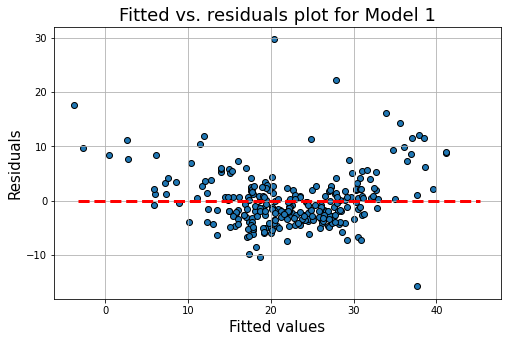

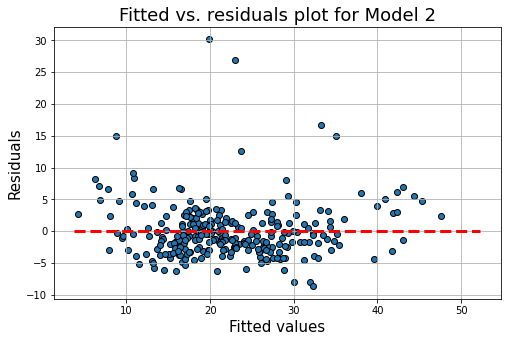

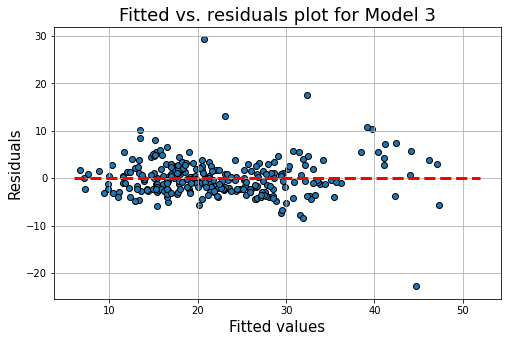

In [39]:
models = [model_1, model_2,model_3]
for model in models:
    plt.figure(figsize=(8,5))
    p=plt.scatter(x=model.fittedvalues,y=model.resid,edgecolor='k')
    xmin = min(model.fittedvalues)
    xmax = max(model.fittedvalues)
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.xlabel("Fitted values",fontsize=15)
    plt.ylabel("Residuals",fontsize=15)
    
    model_name = models.index(model) + 1
    plt.title(f"Fitted vs. residuals plot for Model {model_name}", fontsize=18)
    plt.grid(True)
    plt.show()

### Normalized Residuals Histogram

Model 3 has the most normally distributed residuals.

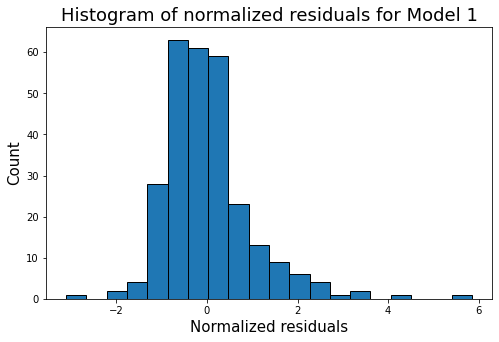

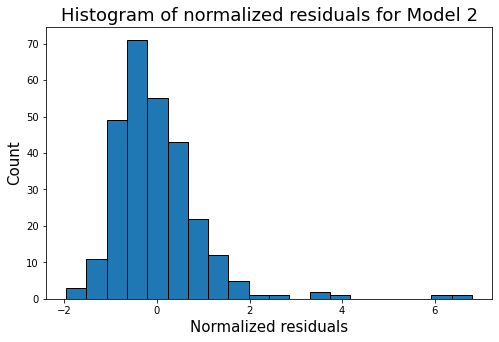

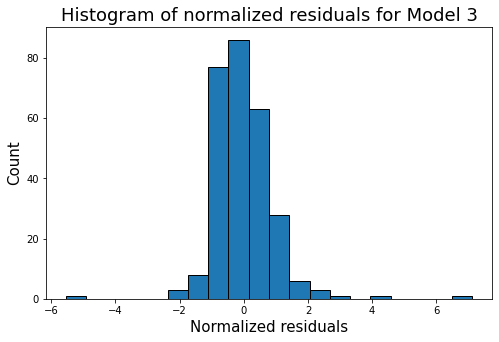

In [40]:
for model in models:
    plt.figure(figsize=(8,5))
    plt.hist(model.resid_pearson,bins=20,edgecolor='k')
    plt.ylabel('Count',fontsize=15)
    plt.xlabel('Normalized residuals',fontsize=15)
    model_name = models.index(model) + 1
    plt.title(f"Histogram of normalized residuals for Model {model_name}",fontsize=18)
    plt.show()

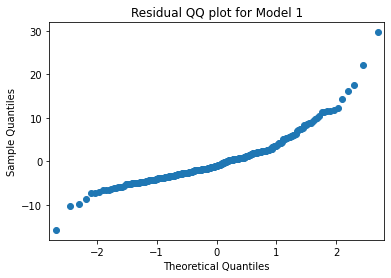

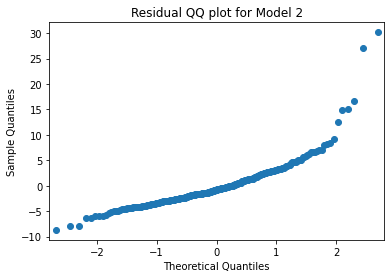

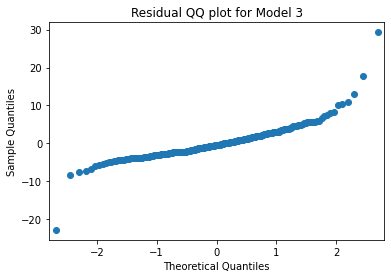

In [41]:
for model in models:
    res = model.resid # residuals
    fig = sm.qqplot(res)
    model_name = models.index(model) + 1
    plt.title(f"Residual QQ plot for Model {model_name}")
    plt.show()

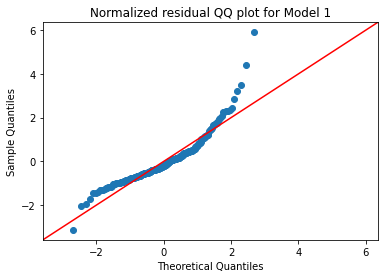

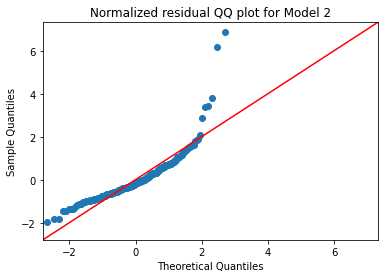

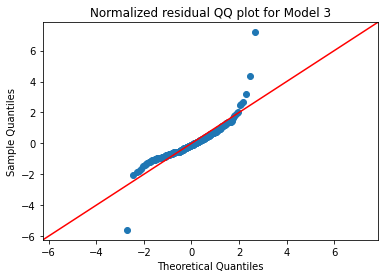

In [42]:
for model in models:
    res = model.resid_pearson # residuals
    fig = sm.qqplot(res, line='45',fit='True')
    model_name = models.index(model) + 1
    plt.title(f"Normalized residual QQ plot for Model {model_name}")
    plt.show()

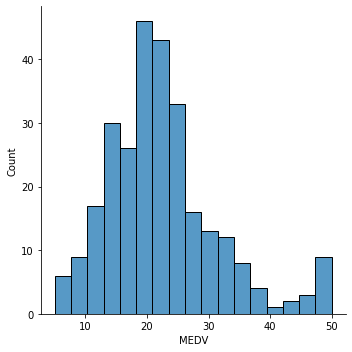

In [43]:
sns.displot(train['MEDV'])
plt.show()

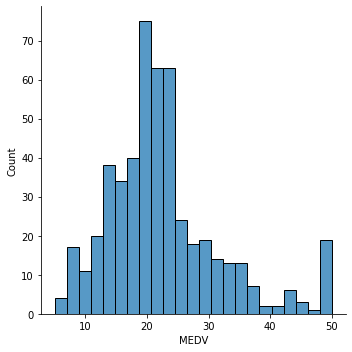

In [44]:
sns.displot(housing['MEDV'])
plt.show()

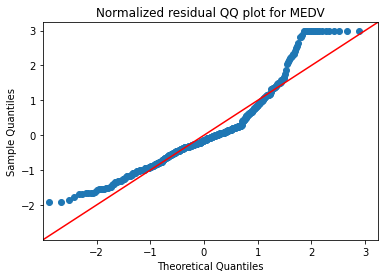

In [45]:
res = housing['MEDV']# residuals
fig = sm.qqplot(res, line='45',fit='True')
plt.title(f"Normalized residual QQ plot for MEDV")
plt.show()

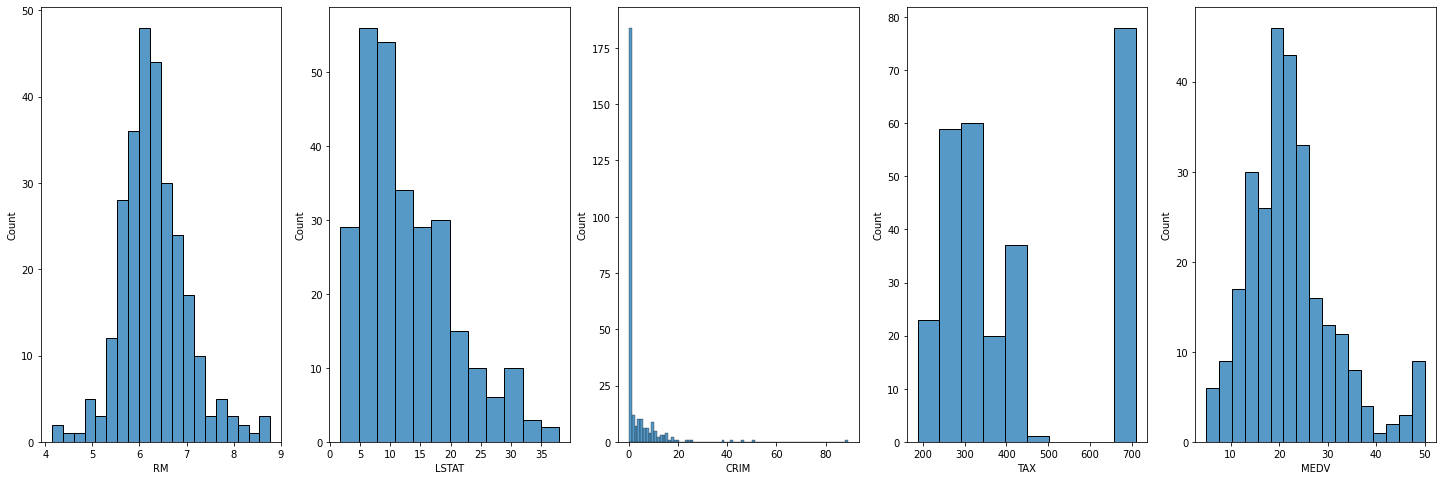

In [46]:
plt.figure(figsize=(25, 8))
plt.subplot(1, 5, 1)
sns.histplot(train['RM'])
plt.subplot(1, 5, 2)
sns.histplot(train['LSTAT'])
plt.subplot(1, 5, 3)
sns.histplot(train['CRIM'])
plt.subplot(1, 5, 4)
sns.histplot(train['TAX'])
plt.subplot(1, 5, 5)
sns.histplot(train['MEDV'])
plt.show()

In [47]:
from statsmodels.stats.outliers_influence import OLSInfluence
cook_distance = OLSInfluence(model_3).cooks_distance
(distance, p_value) = cook_distance

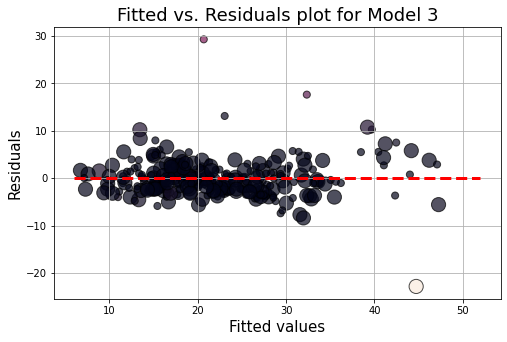

In [48]:
plt.figure(figsize=(8, 5))

p = plt.scatter(x=model_3.fittedvalues, y=model_3.resid, c=distance, s=distance, sizes=(50, 200), edgecolor='black', linewidth=1, alpha=0.7, cmap='rocket')
xmin = min(model_3.fittedvalues)
xmax = max(model_3.fittedvalues)

plt.hlines(y=0, xmin=xmin * 0.9, xmax=xmax * 1.1, color='red', linestyle='--', lw=3)
plt.xlabel("Fitted values", fontsize=15)
plt.ylabel("Residuals", fontsize=15)
plt.title(f"Fitted vs. Residuals plot for Model 3", fontsize=18)
plt.grid(True)
plt.show()

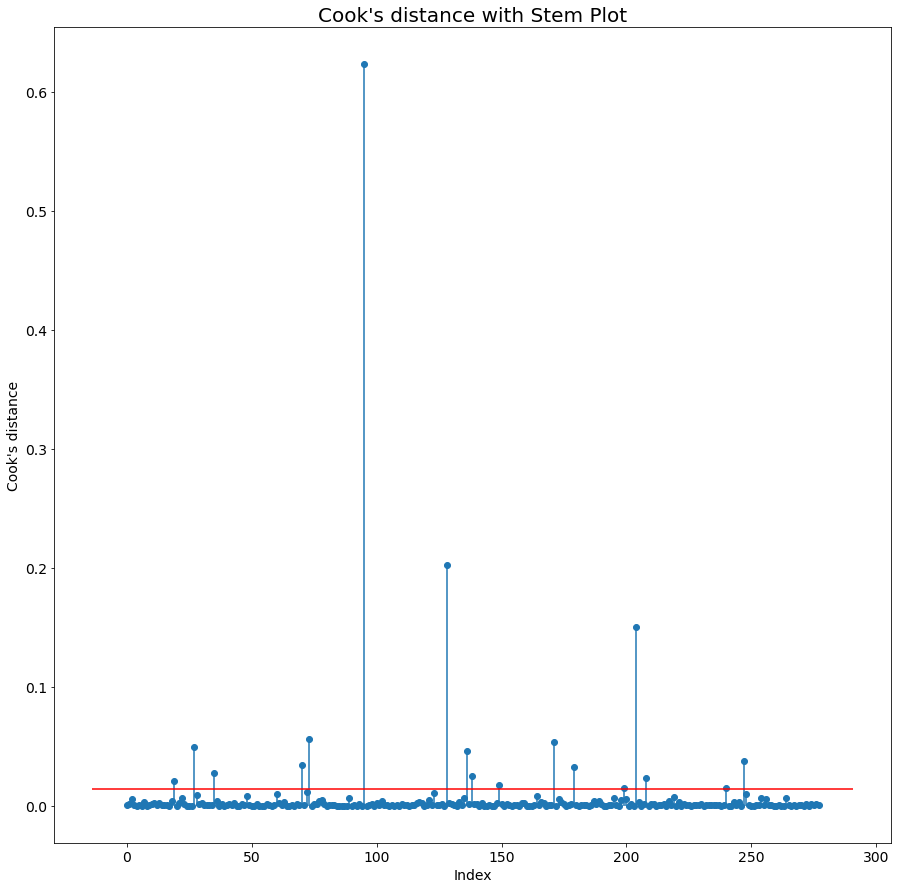

In [49]:
threshold = 4 / len(train)

plt.figure(figsize=(15, 15))

# Stem plot with markers
plt.stem(distance, basefmt=" ", markerfmt="o", linefmt="-", use_line_collection=True)

# Horizontal line showing the threshold value
xmin, xmax = plt.xlim()  # Get the current x-axis limits
plt.hlines(threshold, xmin, xmax, 'r')

# The observations with Cook's distances higher than the threshold value are labeled in the plot
influential_data = distance[distance > threshold]

# Annotate points with labels and adjust the offset for better placement
# for index, value in influential_data.items():
#     plt.text(index, value + 0.03 * max(distance), str(index), fontsize=14, ha='center')  # Adjusted the coordinates and set horizontal alignment to center

# Ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Labels and title
plt.xlabel('Index', fontsize=14)
plt.ylabel("Cook's distance", fontsize=14)
plt.title("Cook's distance with Stem Plot", fontsize=20)

plt.show()

#### Removing influential data points that are in the independent variables

In [50]:
train_without_influential = train.drop(influential_data.index)
train_without_influential

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CRIM_Inv,Ln_MEDV
435,11.16040,0.0,18.10,0.0,0.740,6.629,94.6,2.1247,24,666,20.2,109.85,23.27,13.4,0.089603,2.595255
438,13.67810,0.0,18.10,0.0,0.740,5.935,87.9,1.8206,24,666,20.2,68.95,34.02,8.4,0.073110,2.128232
211,0.37578,0.0,10.59,1.0,0.489,5.404,88.6,3.6650,4,277,18.6,395.24,23.98,19.3,2.661132,2.960105
321,0.18159,0.0,7.38,0.0,0.493,6.376,54.3,4.5404,5,287,19.6,396.90,6.87,23.1,5.506911,3.139833
420,11.08740,0.0,18.10,0.0,0.718,6.411,100.0,1.8589,24,666,20.2,318.75,15.02,16.7,0.090192,2.815409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,10.67180,0.0,18.10,0.0,0.740,6.459,94.8,1.9879,24,666,20.2,43.06,23.98,11.8,0.093705,2.468100
373,11.10810,0.0,18.10,0.0,0.668,4.906,100.0,1.1742,24,666,20.2,396.90,34.77,13.8,0.090024,2.624669
176,0.07022,0.0,4.05,0.0,0.510,6.020,47.2,3.5549,5,296,16.6,393.23,10.11,23.2,14.240957,3.144152
381,15.87440,0.0,18.10,0.0,0.671,6.545,99.1,1.5192,24,666,20.2,396.90,21.08,10.9,0.062995,2.388763


In [51]:
model_3 = ols('MEDV ~ RM + LSTAT + CRIM + TAX + LSTAT:RM', data = train).fit() 
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     215.7
Date:                Sat, 06 Jan 2024   Prob (F-statistic):           2.00e-92
Time:                        14:14:10   Log-Likelihood:                -785.09
No. Observations:                 278   AIC:                             1582.
Df Residuals:                     272   BIC:                             1604.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -35.7069      4.205     -8.491      0.000     -43.986     -27.428
RM            10.5653      0.610     17.333      0.000       9.365      11.765
LSTAT          2.2740      0.229      9.922      0.000       1.823       2.725
CRIM          -0.1141      0.036     -3.130      0.002      -0.186      -0.042
TAX           -0.0036      0.002     -1.789      0.075      -0.008       0.000
LSTAT:RM      -0.4638      0.039    -11.926      0.000      -0.540      -0.387
==============================================================================
Omnibus:                      123.541   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2065.327
Skew:                           1.327   Prob(JB):                         0.00
Kurtosis:                      16.087   Cond. No.                     7.81e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Model 3.1 does not have the influential data points. R-squared increased from .818 to .876 in model 3.1



In [52]:
model_3_1 = ols('MEDV ~ RM + LSTAT + CRIM + TAX + LSTAT:RM', data = train_without_influential).fit() 
model_3_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     354.7
Date:                Sat, 06 Jan 2024   Prob (F-statistic):          1.33e-112
Time:                        14:14:10   Log-Likelihood:                -637.90
No. Observations:                 261   AIC:                             1288.
Df Residuals:                     255   BIC:                             1309.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.4529      3.600    -11.794      0.000     -49.541     -35.364
RM            11.4507      0.528     21.674      0.000      10.410      12.491
LSTAT          2.7001      0.229     11.813      0.000       2.250       3.150
CRIM          -0.1494      0.038     -3.903      0.000      -0.225      -0.074
TAX           -0.0034      0.002     -2.093      0.037      -0.007      -0.000
LSTAT:RM      -0.5222      0.038    -13.597      0.000      -0.598      -0.447
==============================================================================
Omnibus:                        2.119   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                2.193
Skew:                           0.209   Prob(JB):                        0.334
Kurtosis:                       2.833   Cond. No.                     9.35e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# **Discussion**

Here are the changes in the model parameters:

**Model 3.1**'s intercept decreased from -38.801698 to **-41.775934**.

**RM** coefficient increased from 11.048 to **11.423**.

**LSTAT** coefficient increased from 2.3876 to **2.700993**.

**CRIM** coefficient decreased from -.113329 to **-.116900**.

**TAX** coefficient decreased from -.001249 to **--.004053**.

**LSTAT:RM** coefficient decreased from -.493159 to **-.527364**.

The decrease in CRIM, TAX, LSTAT:RM indicates that the high-influence points were exerting a strong influence on the estimation of the regression coefficients.

The increase in RM and LSTAT coefficients indicates that the influential points were surpressing the magnitude of these two coefficients, and those points removal led to better coefficient estimates.

The intercept decrease may indicate that the influential points were impacting the baseline position of the regression point.

### What points could have been "Influential"? -- will take a look below

In [53]:
print("Parameters of Model 3 are\n", model_3.params, "\n")
print("Parameters of Model 3.1 are\n", model_3_1.params,"\n")

Parameters of Model 3 are
 Intercept   -35.706900
RM           10.565317
LSTAT         2.273954
CRIM         -0.114107
TAX          -0.003634
LSTAT:RM     -0.463792
dtype: float64 

Parameters of Model 3.1 are
 Intercept   -42.452872
RM           11.450663
LSTAT         2.700093
CRIM         -0.149401
TAX          -0.003408
LSTAT:RM     -0.522180
dtype: float64 



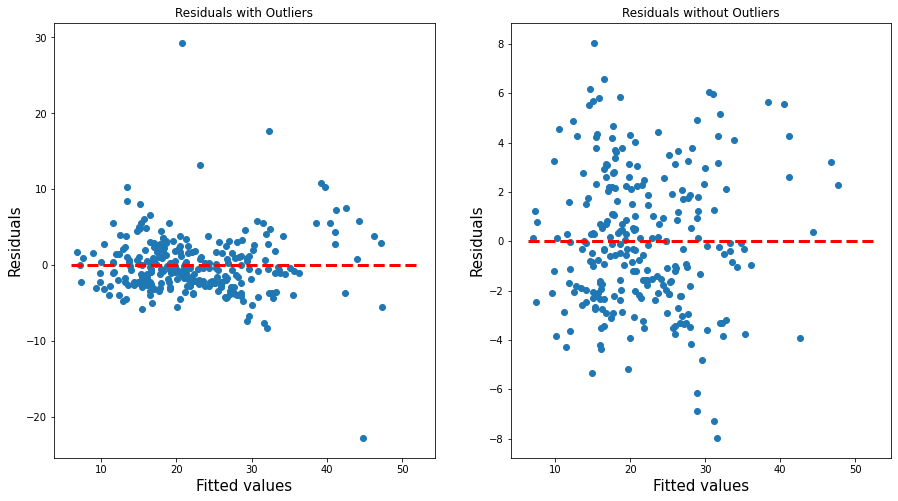

In [54]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.scatter(model_3.fittedvalues, model_3.resid)
xmin = min(model_3.fittedvalues)
xmax = max(model_3.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title('Residuals with Outliers')

plt.subplot(1, 2, 2)
plt.scatter(model_3_1.fittedvalues, model_3_1.resid)
xmin = min(model_3_1.fittedvalues)
xmax = max(model_3_1.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title('Residuals without Outliers')

plt.show()

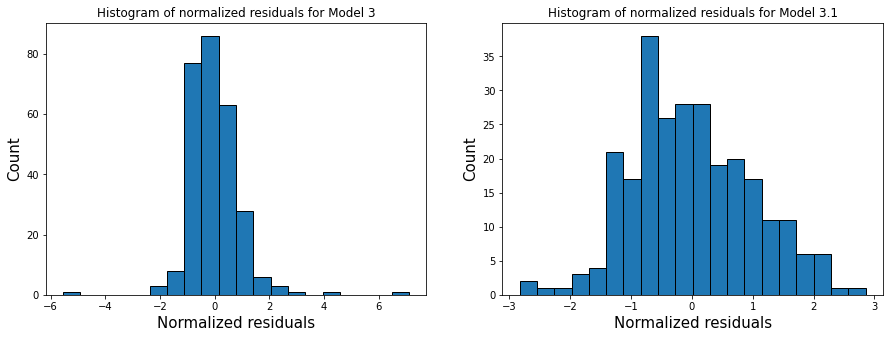

In [55]:
# Change the axes to be the same. This could be misleading? But model 3.1 has more of its own info within 3 standard deviations.

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.hist(model_3.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title(f"Histogram of normalized residuals for Model 3",fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(model_3_1.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title(f"Histogram of normalized residuals for Model 3.1",fontsize=12)

plt.show()

### What points could have been "Influential"?

In **RM**: There seems to be a more even spread of # rooms per dwelling, centering between 6 and 7 rooms per dwelling. There are some outliers where there are some dwellings with more than 8 rooms and some between 4 and 5.

**LSTAT** : could have influential points because of higher pockets of lower status in metropolitan areas exist.

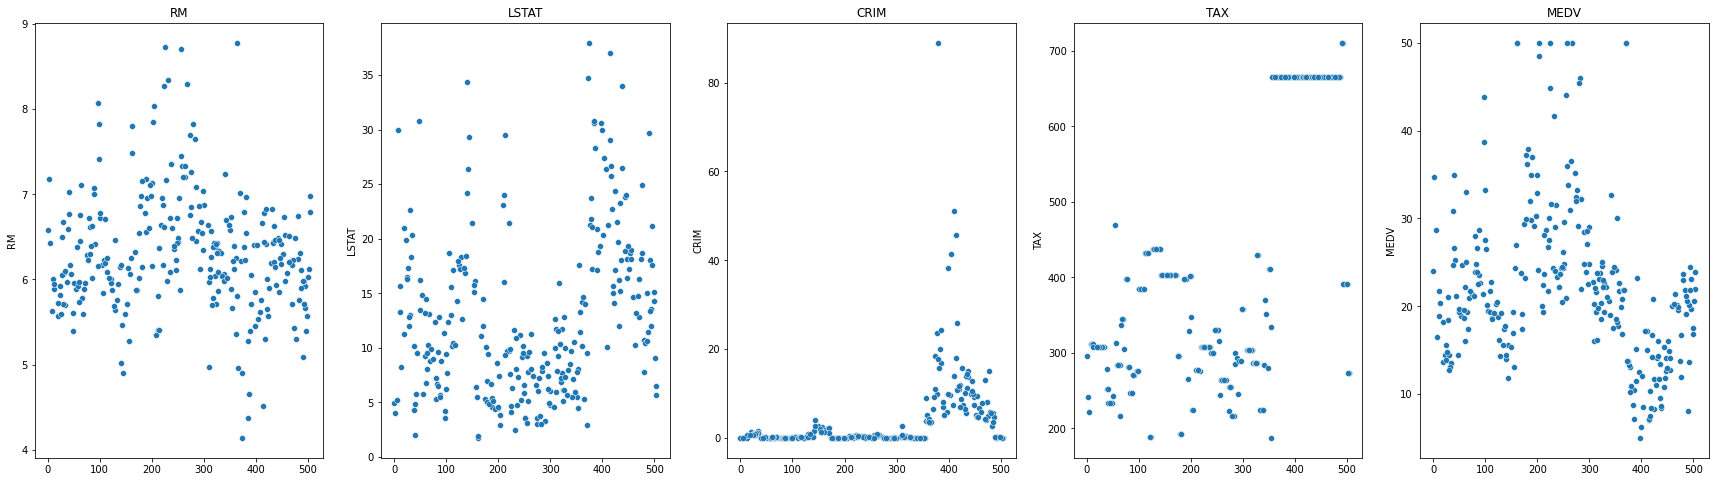

In [56]:
plt.figure(figsize=(30, 8))
plt.subplot(1, 5, 1)
sns.scatterplot(train['RM'])
plt.title('RM')
plt.subplot(1, 5, 2)
sns.scatterplot(train['LSTAT'])
plt.title('LSTAT')
plt.subplot(1, 5, 3)
sns.scatterplot(train['CRIM'])
plt.title('CRIM')
plt.subplot(1, 5, 4)
sns.scatterplot(train['TAX'])
plt.title('TAX')
plt.subplot(1, 5, 5)
sns.scatterplot(train['MEDV'])
plt.title('MEDV')
plt.show()

In [57]:
validation_pred_3 = model_3.predict(validate)
print(validation_pred_3)

336    21.092145
76     21.535492
279    31.160856
382    12.385042
218    17.441171
         ...    
208    19.444839
244    18.161655
272    26.683818
331    18.838772
475    12.173880
Length: 77, dtype: float64


In [58]:
mse_3 = mean_sq_error(valid_actual_3, validation_pred_3)
print("MSE for Model 3 with the validation data:",mse_3)

MSE for Model 3 with the validation data: 10.602933002044848


In [59]:
rmse_3 = mean_sq_error(valid_actual_3, validation_pred_3) ** .5
print("RMSE for Model 3 with the validation data:",rmse_3)

RMSE for Model 3 with the validation data: 3.2562145202742476


In [60]:
validation_pred_3_1 = model_3_1.predict(validate)
print(validation_pred_3_1)

336    20.409614
76     21.147457
279    30.625000
382    12.795157
218    17.432221
         ...    
208    19.182063
244    17.679440
272    26.115810
331    18.367248
475    12.407421
Length: 77, dtype: float64


In [61]:
mse_3_1 = mean_sq_error(valid_actual_3, validation_pred_3_1)
print("MSE for Model 3.1 with the validation data:",mse_3_1)

MSE for Model 3.1 with the validation data: 10.588001853125167


In [62]:
rmse_3_1 = mean_sq_error(valid_actual_3, validation_pred_3_1) ** .5
print("RMSE for Model 3.1 with the validation data:",rmse_3_1)

RMSE for Model 3.1 with the validation data: 3.253920996755325


Because there is not a huge change in RSME of model's 3 and 3.1, the points that were removed were only **high leverage** not **highly influential**


THE CONTEXT OF THE VALUE OF THE RSME WILL MATTER. SINCE RSME IS IN THE UNIT OF THE RESPONSE (MEDV - MEDIAN VALUE IN THE 1000$), MAYBE 300$ IS IMPORTANT FOR SOME PEOPLE.model

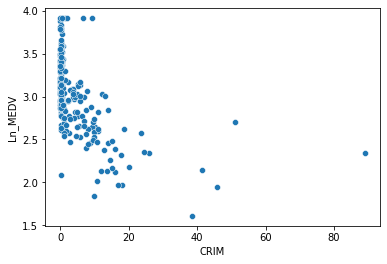

In [63]:
sns.scatterplot(data=train, x='CRIM', y='Ln_MEDV')
plt.show()

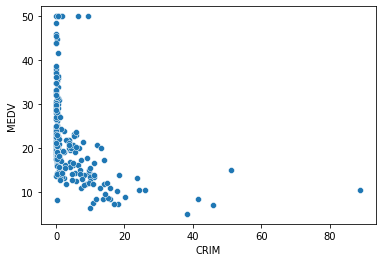

In [64]:
sns.scatterplot(data=train, x='CRIM', y='MEDV')
plt.show()

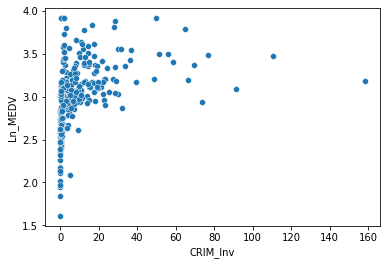

In [65]:
sns.scatterplot(data=train, x='CRIM_Inv', y='Ln_MEDV')
plt.show()